# **1. Load and Explore the Dataset**

## **1.1 Load Required Libraries**

In [1]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## **1.2: Load First 5000 Rows of Dataset**

In [2]:
df = pd.read_csv('/media/nsriad/Documents/UAH/Spring 25/OS-Lawrence/Project/Code/processes_datasets.csv')
print("Shape:", df.shape)
df.head()

Shape: (404176, 29)


,JobID,SubmitTime,WaitTime,RunTime,NProcs,AverageCPUTimeUsed,Used Memory,ReqNProcs,ReqTime:,ReqMemory,...,JobStructureParams,UsedNetwork,UsedLocalDiskSpace,UsedResources,ReqPlatform,ReqNetwork,ReqLocalDiskSpace,ReqResources,VOID,ProjectID
0,1,1136070024,203761,138467,1,138371,98652,1,259200,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2,1136070690,0,11,1,4,35848,1,259200,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,3,1136071207,117,201203,1,0,0,1,259200,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,4,1136071267,4406,196985,1,0,0,1,259200,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,5,1136071269,202516,19520,1,18731,522268,1,259200,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [3]:
df.columns

Index(['JobID', 'SubmitTime', 'WaitTime', 'RunTime ', 'NProcs',
       'AverageCPUTimeUsed', 'Used Memory', 'ReqNProcs', 'ReqTime: ',
       'ReqMemory', 'Status', 'UserID', 'GroupID', 'ExecutableID', 'QueueID',
       'PartitionID', 'OrigSiteID', 'LastRunSiteID', 'JobStructure',
       'JobStructureParams', 'UsedNetwork', 'UsedLocalDiskSpace',
       'UsedResources', 'ReqPlatform', 'ReqNetwork', 'ReqLocalDiskSpace',
       'ReqResources', 'VOID', 'ProjectID'],
      dtype='object')

In [4]:
selected_columns = ['SubmitTime', 'UserID', 'Used Memory', 'ReqTime: ', 'ReqMemory', 'RunTime ']
df_filtered = df[selected_columns].copy()
#df_filtered = df_filtered[df_filtered['RunTime '] > 0]  # remove rows with 0 or invalid target
print("Selected features and target:", df_filtered.columns.tolist())
df_filtered.head()

Selected features and target: ['SubmitTime', 'UserID', 'Used Memory', 'ReqTime: ', 'ReqMemory', 'RunTime ']


,SubmitTime,UserID,Used Memory,ReqTime:,ReqMemory,RunTime
0,1136070024,U2004S1,98652,259200,-1,138467
1,1136070690,U1023S0,35848,259200,-1,11
2,1136071207,U2035S1,0,259200,-1,201203
3,1136071267,U2035S1,0,259200,-1,196985
4,1136071269,U2035S1,522268,259200,-1,19520


In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_filtered['UserID'] = le.fit_transform(df_filtered['UserID'])

In [6]:
df_filtered.columns

Index(['SubmitTime', 'UserID', 'Used Memory', 'ReqTime: ', 'ReqMemory',
       'RunTime '],
      dtype='object')

In [7]:
# using first 5000 datatpoints
df_filtered = df_filtered.head(5000)
print("Shape:", df_filtered.shape)

Shape: (5000, 6)


In [8]:
# exclude process with no burst time i.e., -1
df_filtered = df_filtered[df_filtered['RunTime '] != -1]
print("Shape:", df_filtered.shape)

Shape: (4340, 6)


In [9]:
df_filtered.head(10)

,SubmitTime,UserID,Used Memory,ReqTime:,ReqMemory,RunTime
0,1136070024,133,98652,259200,-1,138467
1,1136070690,27,35848,259200,-1,11
2,1136071207,167,0,259200,-1,201203
3,1136071267,167,0,259200,-1,196985
4,1136071269,167,522268,259200,-1,19520
5,1136072890,21,49216,900,-1,46
6,1136074263,364,35712,5400,-1,21
7,1136074695,38,0,259200,-1,197831
8,1136074754,38,0,259200,-1,197682
9,1136074756,38,0,259200,-1,197552


## **1.5 Split dataset**

In [10]:
# Target
y = df_filtered['RunTime ']

# Features
X = df_filtered.drop(columns=['RunTime '])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3472, 5)
y_train shape: (3472,)
X_test shape: (868, 5)
y_test shape: (868,)


## **1.6: Normalize data**

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# # Normalize minmax
# scaler_X = MinMaxScaler()
# X_train = scaler_X.fit_transform(X_train)
# X_test = scaler_X.transform(X_test)

# **2. Train ML Models on Filtered Data**

## **2.1: Evaluation function**

In [12]:
def evaluate_regression_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    cc = np.corrcoef(y_test, y_pred)[0, 1]
    rae = np.sum(np.abs(y_test - y_pred)) / np.sum(np.abs(y_test - np.mean(y_test)))

    return {
        'MAE': mae,
        'R2': r2,
        'CC': cc,
        'RAE (%)': rae * 100
    }

## **2.2: Training Models**

In [13]:
results = {}

# KNN
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
results['KNN'] = evaluate_regression_model(knn, X_test, y_test)

# SVR (with RBF kernel)
svr = SVR(kernel='rbf', C=100, gamma=0.1)
svr.fit(X_train, y_train)
results['SVR'] = evaluate_regression_model(svr, X_test, y_test)

# Decision Tree (like REPtree)
dtree = DecisionTreeRegressor(random_state=42)
dtree.fit(X_train, y_train)
results['DecisionTree'] = evaluate_regression_model(dtree, X_test, y_test)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
results['RandomForest'] = evaluate_regression_model(rf, X_test, y_test)

In [55]:
import time
import numpy as np

def measure_inference_time(model, X_test, framework='sklearn'):
    """
    Measure total and per-sample inference time for a given model.

    Parameters:
        model     : Trained model object (scikit-learn or PyTorch)
        X_test    : Test input data (NumPy array or tensor)
        framework : 'sklearn' or 'torch'

    Returns:
        total_time: Total inference time (seconds)
        per_sample_ms: Inference time per sample (milliseconds)
    """
    if framework == 'sklearn':
        start = time.time()
        _ = model.predict(X_test)
        end = time.time()

    elif framework == 'torch':
        import torch
        model.eval()
        with torch.no_grad():
            if not isinstance(X_test, torch.Tensor):
                X_test = torch.tensor(X_test, dtype=torch.float32)

            start = time.time()
            _ = model(X_test)
            end = time.time()

    else:
        raise ValueError("Unsupported framework. Use 'sklearn' or 'torch'.")

    total_time = end - start
    per_sample_ms = (total_time / len(X_test)) * 1000

    return total_time, per_sample_ms

### Random Forest Inference time

In [81]:
total, per_sample = measure_inference_time(rf, X_test, framework='sklearn')
print(f"Random Forest → Total: {total:.4f}s, Per-sample: {per_sample:.4f}ms")

Random Forest → Total: 0.0539s, Per-sample: 0.0622ms


In [82]:
total, per_sample = measure_inference_time(rf, X_test, framework='sklearn')
print(f"Random Forest → Total: {total:.4f}s, Per-sample: {per_sample:.4f}ms")

Random Forest → Total: 0.0572s, Per-sample: 0.0659ms


In [83]:
total, per_sample = measure_inference_time(rf, X_test, framework='sklearn')
print(f"Random Forest → Total: {total:.4f}s, Per-sample: {per_sample:.4f}ms")

Random Forest → Total: 0.0619s, Per-sample: 0.0714ms


### KNN Inference time

In [84]:
total, per_sample = measure_inference_time(knn, X_test, framework='sklearn')
print(f"KNN → Total: {total:.4f}s, Per-sample: {per_sample:.4f}ms")

KNN → Total: 0.0107s, Per-sample: 0.0123ms


In [113]:
total, per_sample = measure_inference_time(knn, X_test, framework='sklearn')
print(f"KNN → Total: {total:.4f}s, Per-sample: {per_sample:.4f}ms")

KNN → Total: 0.0119s, Per-sample: 0.0137ms


In [114]:
total, per_sample = measure_inference_time(knn, X_test, framework='sklearn')
print(f"KNN → Total: {total:.4f}s, Per-sample: {per_sample:.4f}ms")

KNN → Total: 0.0112s, Per-sample: 0.0128ms


### Decision Tree Inference

In [115]:
total, per_sample = measure_inference_time(dtree, X_test, framework='sklearn')
print(f"DT → Total: {total:.4f}s, Per-sample: {per_sample:.4f}ms")

DT → Total: 0.0035s, Per-sample: 0.0040ms


In [116]:
total, per_sample = measure_inference_time(dtree, X_test, framework='sklearn')
print(f"DT → Total: {total:.4f}s, Per-sample: {per_sample:.4f}ms")

DT → Total: 0.0018s, Per-sample: 0.0021ms


In [117]:
total, per_sample = measure_inference_time(dtree, X_test, framework='sklearn')
print(f"DT → Total: {total:.4f}s, Per-sample: {per_sample:.4f}ms")

DT → Total: 0.0034s, Per-sample: 0.0039ms


### MLP inference time

In [ ]:
total, per_sample = measure_inference_time(mlp_model, X_test, framework='torch')
print(f"MLP → Total: {total:.4f}s, Per-sample: {per_sample:.4f}ms")

# **3. Model Evaluation and Prediction**

## **3.1: Evaluation metrics**

In [14]:
import pandas as pd

result_df = pd.DataFrame(results).T.round(3)
result_df

,MAE,R2,CC,RAE (%)
KNN,2668.105,0.846,0.920,9.594
SVR,21292.323,-0.274,0.092,76.564
DecisionTree,3616.850,0.665,0.840,13.006
RandomForest,2842.303,0.811,0.902,10.220


## **3.2: Prediction**

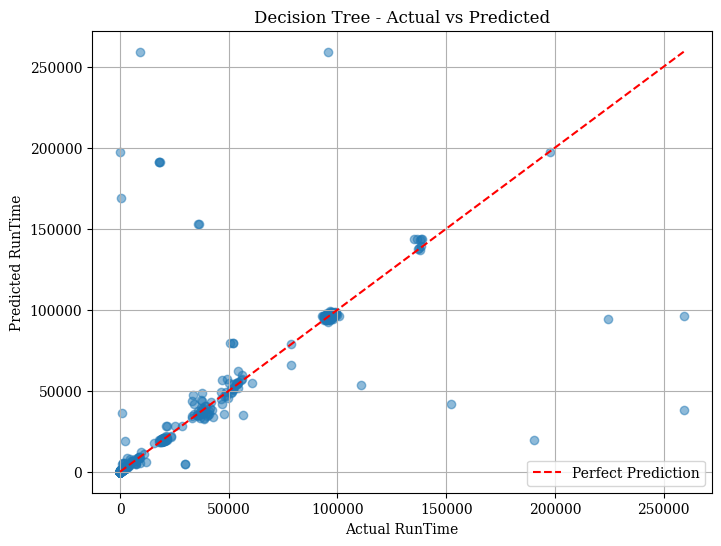

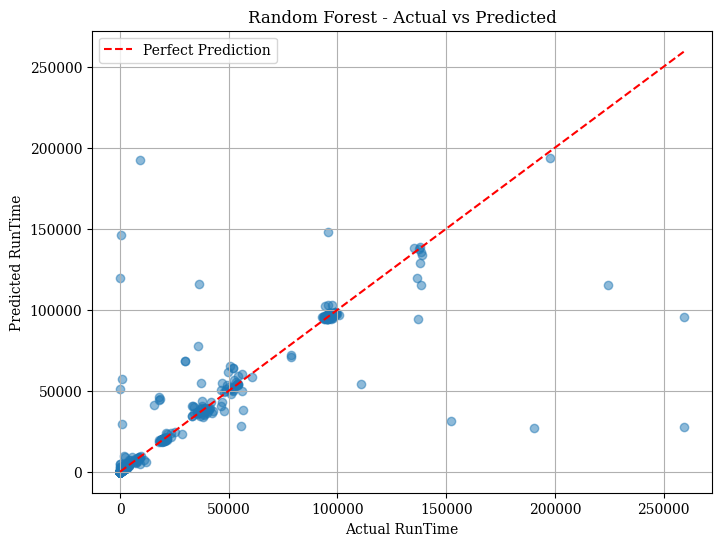

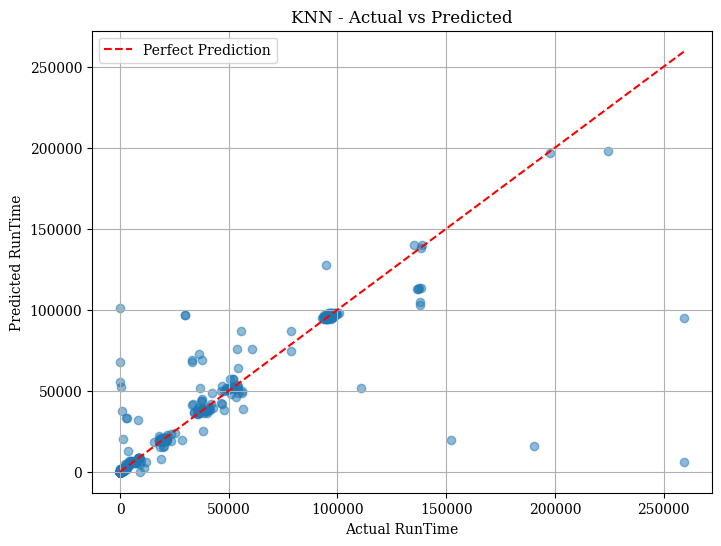

In [15]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']


def plot_actual_vs_predicted(model, X_test, y_test, title=""):
    y_pred = model.predict(X_test)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', label='Perfect Prediction')
    plt.xlabel("Actual RunTime")
    plt.ylabel("Predicted RunTime")
    plt.title(f"{title} - Actual vs Predicted")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for Decision Tree
plot_actual_vs_predicted(dtree, X_test, y_test, title="Decision Tree")

# Plot for Random Forest
plot_actual_vs_predicted(rf, X_test, y_test, title="Random Forest")

# Plot for Knn
plot_actual_vs_predicted(knn, X_test, y_test, title="KNN")

## **Implementing Exponential Averaging**

In [16]:
def exponential_averaging(true_values, alpha=0.5, tau0=None):
    predictions = []

    if tau0 is None:
        tau = np.mean(true_values[:10])  # initial guess
    else:
        tau = tau0

    for t in true_values:
        predictions.append(tau)
        tau = alpha * t + (1 - alpha) * tau  # update for next round

    return np.array(predictions)

In [17]:
# Merge X_test with y_test_raw
df_test = X_test.copy()
df_test['RunTime'] = y_test

# Sort by SubmitTime
df_test_sorted = df_test.sort_values(by='SubmitTime').reset_index(drop=True)

In [18]:
# Actual burst times
actual_bursts = df_test_sorted['RunTime'].values
y_ea_pred = exponential_averaging(actual_bursts, alpha=0.5)
y_ea_true = actual_bursts

In [29]:
# Alphas to try
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
ea_predictions = {f"Alpha={alpha}": exponential_averaging(actual_bursts, alpha=alpha) for alpha in alphas}

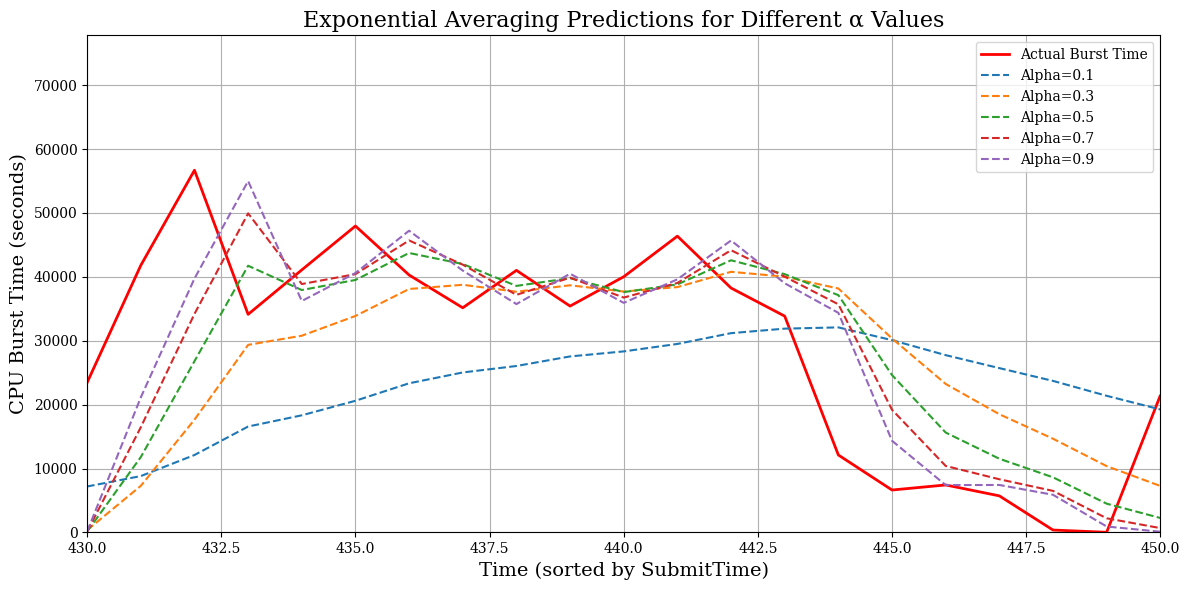

In [40]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(actual_bursts, label='Actual Burst Time', color='red', linewidth=2)

for label, preds in ea_predictions.items():
    plt.plot(preds, label=label, linestyle='--')

plt.title("Exponential Averaging Predictions for Different α Values", fontsize=16)
plt.xlabel("Time (sorted by SubmitTime)", fontsize=14)
plt.ylabel("CPU Burst Time (seconds)", fontsize=14)

# Set axis limits for clarity
plt.xlim(430, 450)             # Show first 100 jobs
plt.ylim(0, max(actual_bursts)*0.3)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Function to calculate evaluation metrics
def evaluate(true, pred):
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    cc = np.corrcoef(true, pred)[0, 1]
    rae = np.sum(np.abs(true - pred)) / np.sum(np.abs(true - np.mean(true)))
    return {
        'MAE': mae,
        'R2': r2,
        'CC': cc,
        'RAE (%)': rae * 100
    }

# Evaluate for multiple alpha values
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
results_per_alpha = {}

for alpha in alphas:
    preds = exponential_averaging(actual_bursts, alpha)
    results_per_alpha[f'α={alpha}'] = evaluate(actual_bursts, preds)

# Create DataFrame for easier viewing
df_alpha_results = pd.DataFrame(results_per_alpha).T
df_alpha_results.index.name = 'Alpha'
df_alpha_results.reset_index(inplace=True)

df_alpha_results


,Alpha,MAE,R2,CC,RAE (%)
0,α=0.1,20235.383923,0.245874,0.500242,72.763181
1,α=0.3,16372.224722,0.340125,0.598569,58.871883
2,α=0.5,14833.003710,0.322339,0.604749,53.337092
3,α=0.7,14047.792139,0.260011,0.588406,50.513598
4,α=0.9,13605.326716,0.157754,0.560904,48.922564


In [19]:
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_ea_true, y_ea_pred)
r2 = r2_score(y_ea_true, y_ea_pred)
cc = np.corrcoef(y_ea_true, y_ea_pred)[0, 1]
rae = np.sum(np.abs(y_ea_true - y_ea_pred)) / np.sum(np.abs(y_ea_true - np.mean(y_ea_true)))

ea_results = {
    'MAE': mae,
    'R2': r2,
    'CC': cc,
    'RAE (%)': rae * 100
}

In [20]:
print("Exponential Averaging Results:")
for k, v in ea_results.items():
    print(f"{k}: {v:.4f}")

Exponential Averaging Results:
MAE: 14833.0037
R2: 0.3223
CC: 0.6047
RAE (%): 53.3371


In [21]:
def plot_ea_actual_vs_predicted(y_true, y_pred, alpha_val=0.5):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
             'r--', label='Perfect Prediction')
    plt.xlabel("Actual RunTime")
    plt.ylabel("Predicted RunTime")
    plt.title(f"Exponential Averaging (α={alpha_val}) - Actual vs Predicted")
    plt.legend()
    plt.grid(True)
    plt.show()

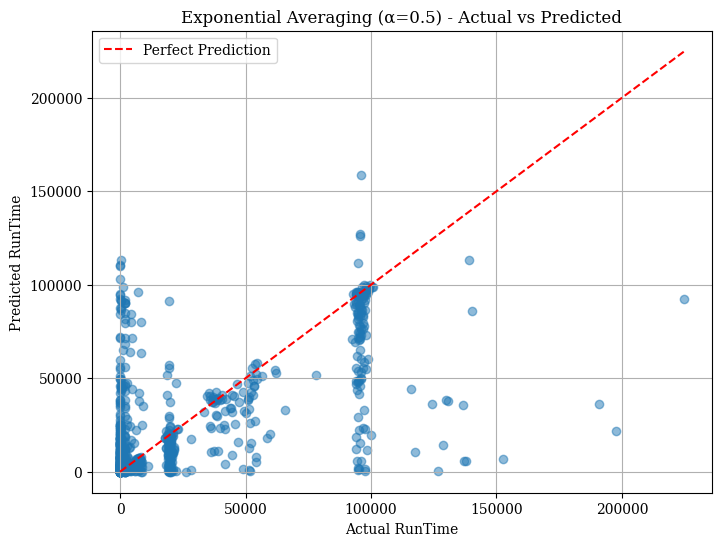

In [35]:
plot_ea_actual_vs_predicted(y_ea_true, y_ea_pred, alpha_val=0.5)

## **ML preds**

In [22]:
# ML prediction (e.g., RF)
X_sorted = df_test_sorted.drop(columns=['RunTime'])
rf_preds = rf.predict(X_sorted)
dt_preds = dtree.predict(X_sorted)
knn_preds = knn.predict(X_sorted)

In [23]:
class MLPRegressor(nn.Module):
    def __init__(self, input_size):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.model(x)

In [24]:
input_size = X_test.shape[1]  # use the correct dimension

model = MLPRegressor(input_size=input_size)
model.load_state_dict(torch.load('non_hist_mlp_burst_predictor.pth')) 
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [25]:
# Apply scaling
from sklearn.preprocessing import MinMaxScaler

# Normalize minmax
scaler_X = MinMaxScaler()
X_sorted = scaler_X.fit_transform(X_sorted)
X_sorted_scaled = scaler_X.transform(X_sorted)

/home/nsriad/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [26]:
X_tensor = torch.tensor(X_sorted_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    y_mlp_pred = model(X_tensor).cpu().numpy().flatten()

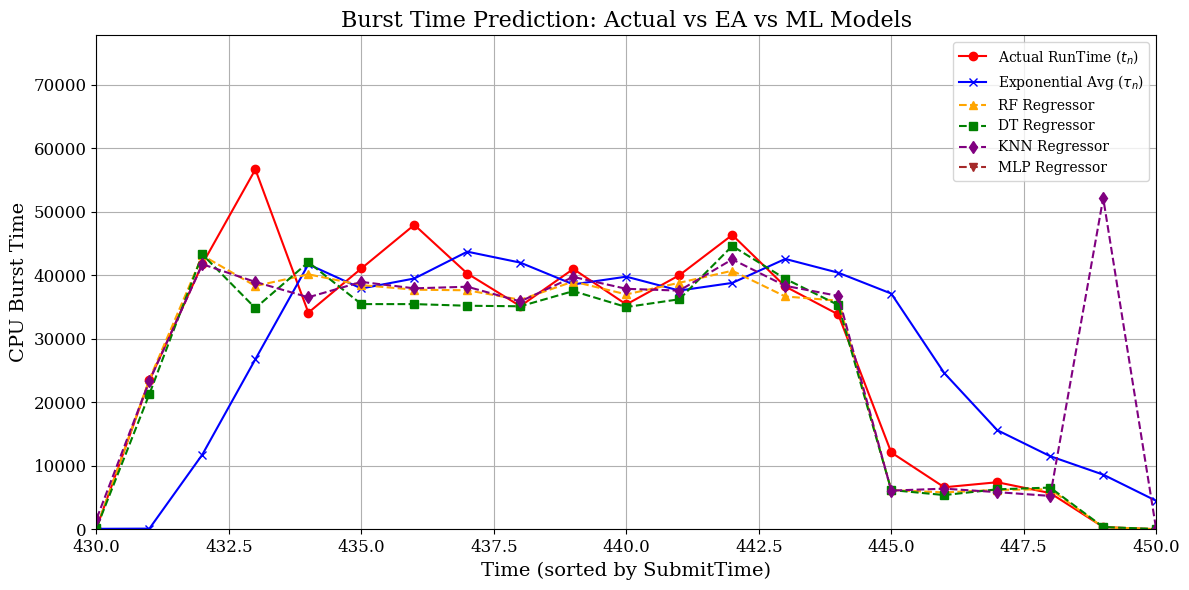

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Serial indices for x-axis
indices = list(range(1, len(actual_bursts) + 1))

plt.plot(indices, actual_bursts, label='Actual RunTime ($t_n$)', color='red', marker='o', linestyle='-', linewidth=1.5)
plt.plot(indices, y_ea_pred, label='Exponential Avg ($\\tau_n$)', color='blue', marker='x', linestyle='-')
plt.plot(indices, rf_preds, label='RF Regressor', color='orange', marker='^', linestyle='--')
plt.plot(indices, dt_preds, label='DT Regressor', color='green', marker='s', linestyle='--')
plt.plot(indices, knn_preds, label='KNN Regressor', color='purple', marker='d', linestyle='--')
plt.plot(indices, y_mlp_pred, label='MLP Regressor', color='brown', marker='v', linestyle='--')

# Set axis limits for clarity
plt.xlim(430, 450)             # Show first 100 jobs
plt.ylim(0, max(y_test)*.30) 

plt.xlabel("Time (sorted by SubmitTime)",fontsize=14)
plt.ylabel("CPU Burst Time",fontsize=14)
plt.title("Burst Time Prediction: Actual vs EA vs ML Models",fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_268217/90565691.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(df['Model'], rotation=0, fontsize=14)
/tmp/ipykernel_268217/90565691.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(df['Model'], rotation=0, fontsize=14)
/tmp/ipykernel_268217/90565691.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(df['Model'], rotation=0, fontsize=14)
/tmp/ipykernel_268217/90565691.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(df['Model'], rotation=0, fontsize=14)


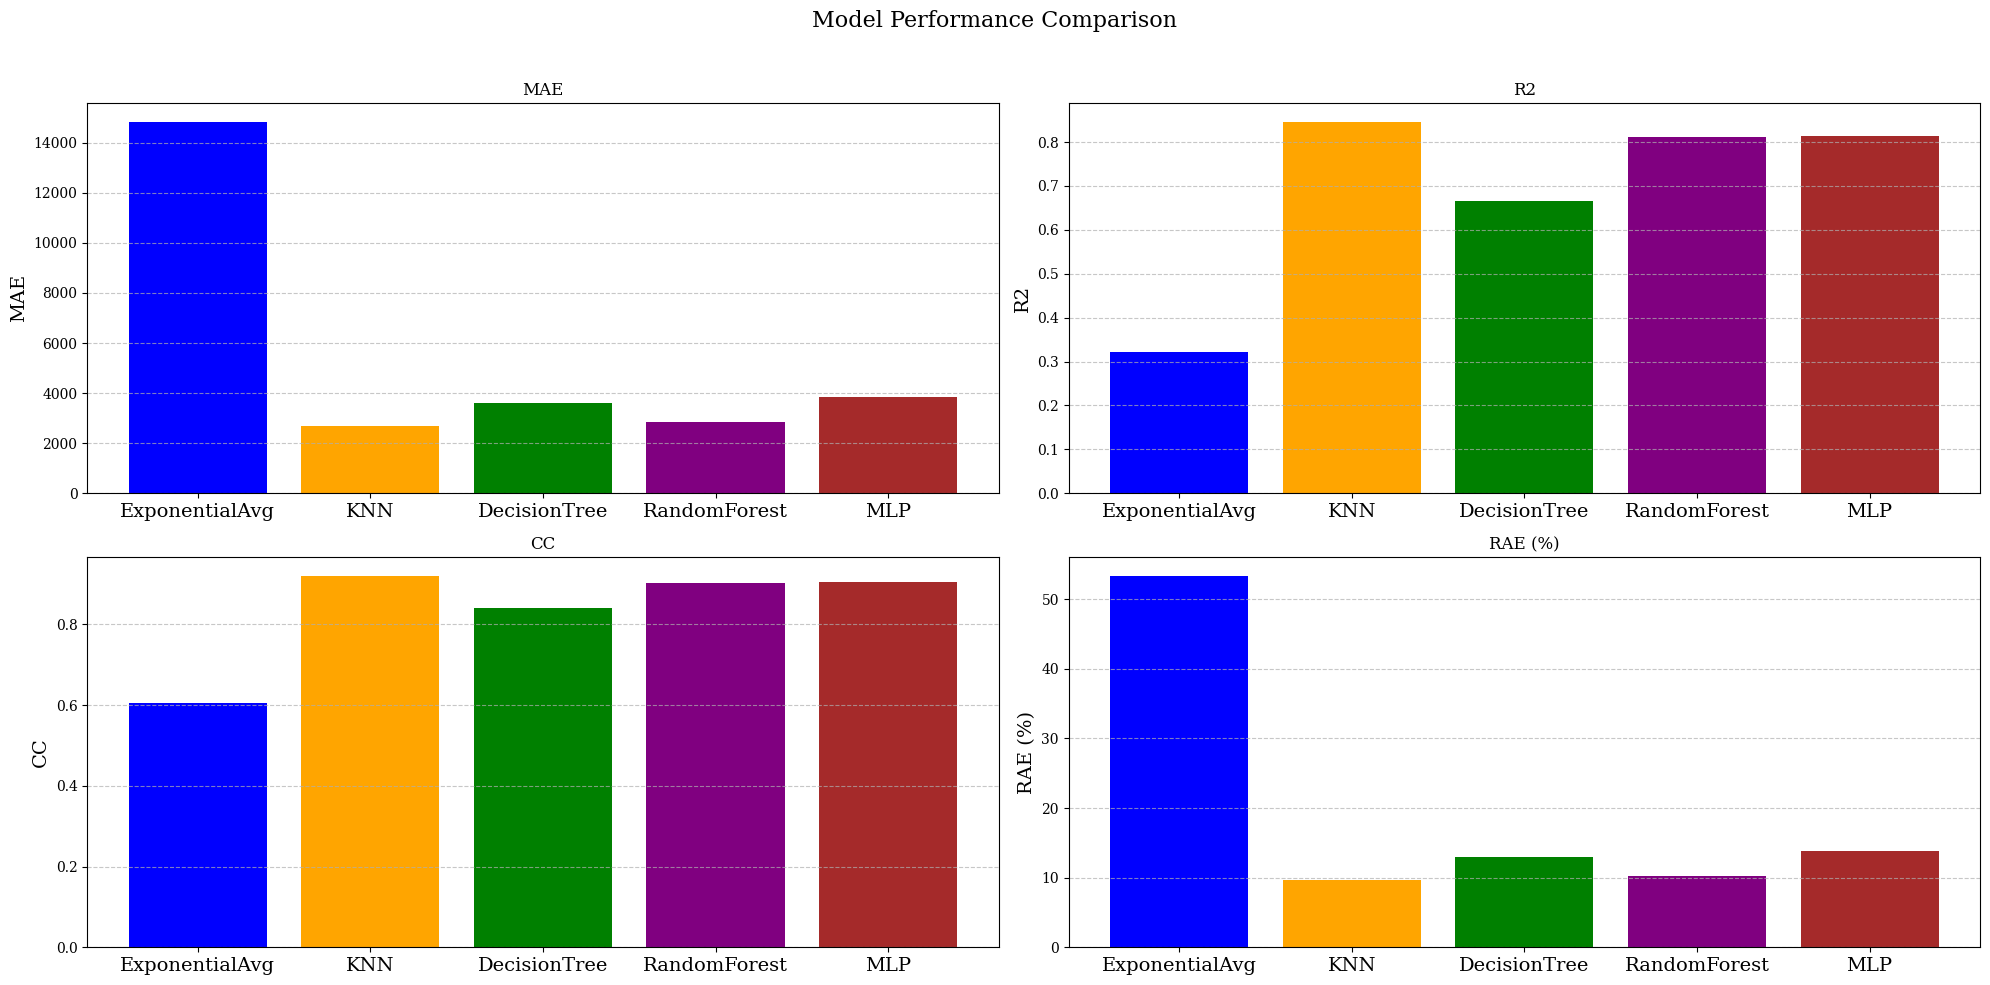

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

# Define model performance metrics (excluding SVR)
data = {
    'Model': ['ExponentialAvg', 'KNN', 'DecisionTree', 'RandomForest', 'MLP'],
    'MAE': [14833.0037, 2668.105, 3616.850, 2842.303, 3853.6431],
    'R2': [0.3223, 0.846, 0.665, 0.811, 0.8136],
    'CC': [0.6047, 0.920, 0.840, 0.902, 0.9037],
    'RAE (%)': [53.3371, 9.594, 13.006, 10.220, 13.8571]
}

df = pd.DataFrame(data)

# Plot
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()
metrics = ['MAE', 'R2', 'CC', 'RAE (%)']

for i, metric in enumerate(metrics):
    axs[i].bar(df['Model'], df[metric], color=['blue', 'orange', 'green', 'purple', 'brown'])
    axs[i].set_title(metric)
    axs[i].set_ylabel(metric, fontsize=14)
    axs[i].set_xticklabels(df['Model'], rotation=0, fontsize=14)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle("Model Performance Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

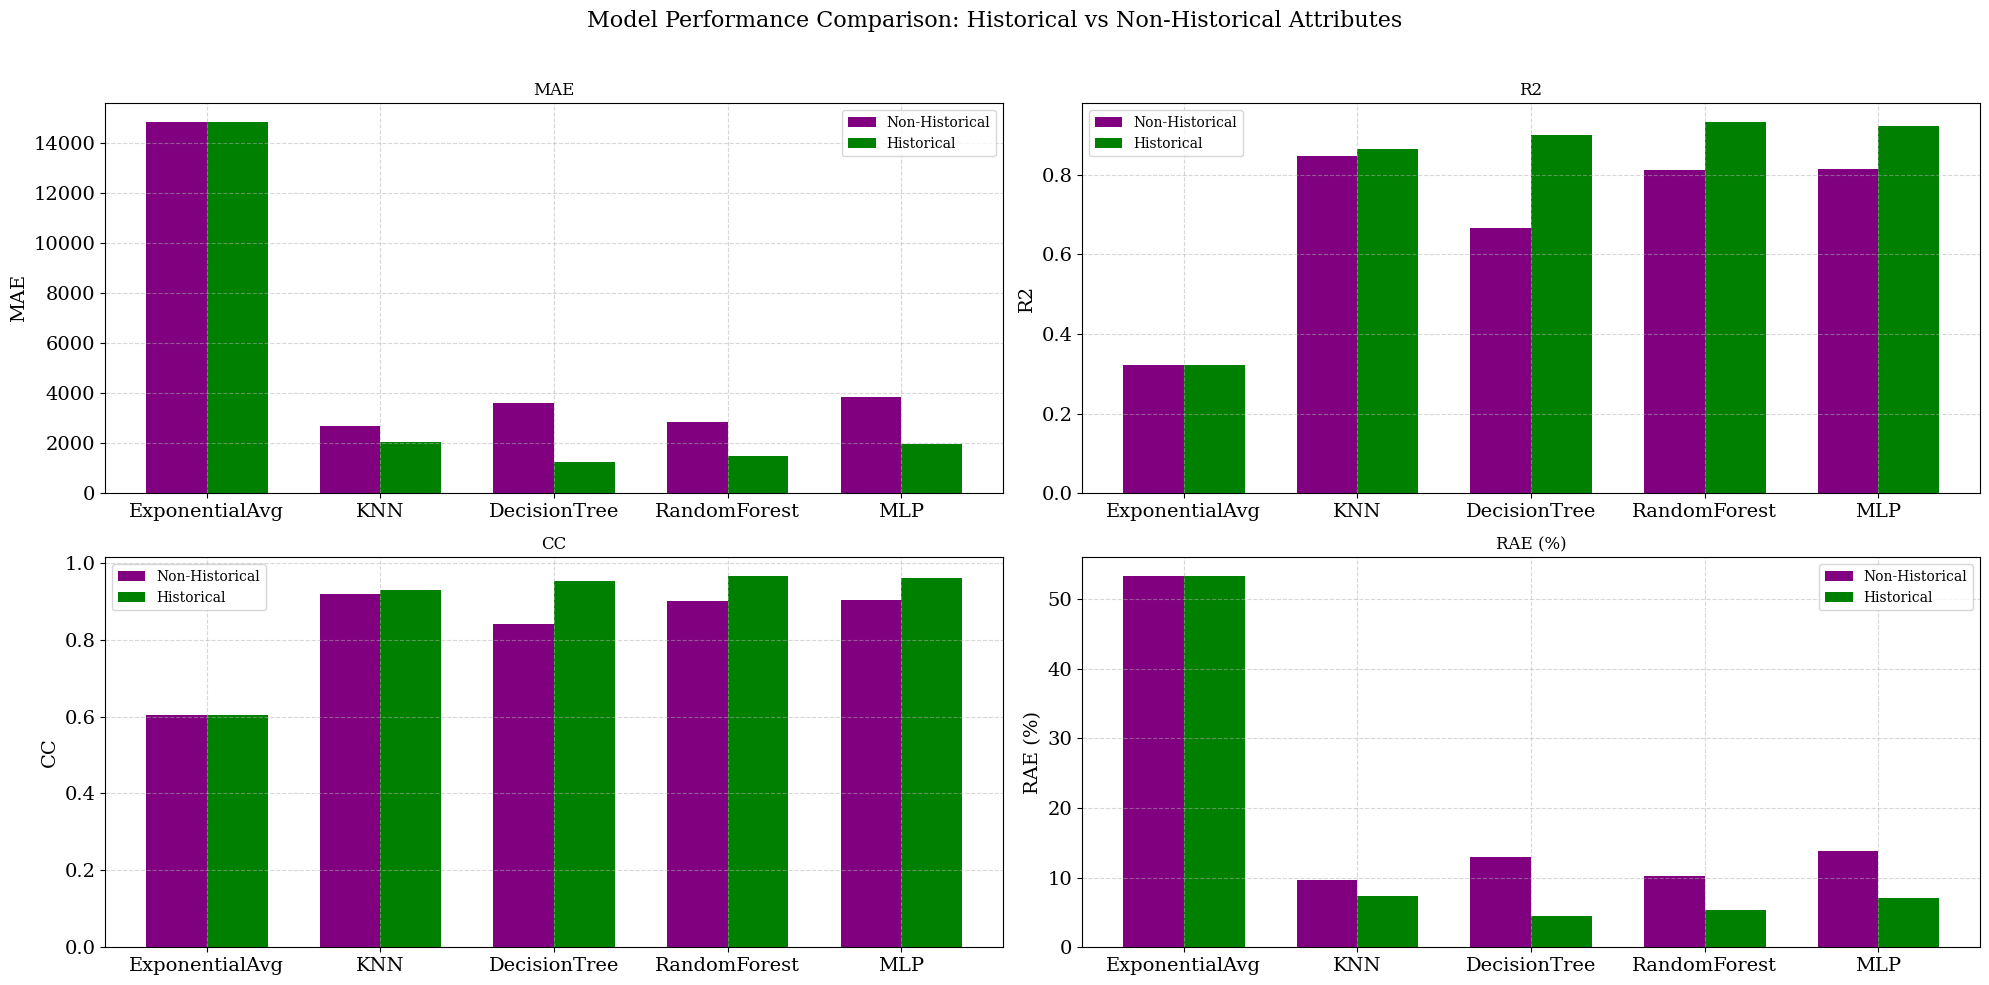

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Recreate the provided data after kernel reset
hist_data = {
    'Model': ['ExponentialAvg', 'KNN', 'DecisionTree', 'RandomForest', 'MLP'],
    'MAE': [14833.0037, 2040.680, 1243.337, 1502.767, 1958.7623],
    'R2': [0.3223, 0.863, 0.898, 0.932, 0.9213],
    'CC': [0.6047, 0.929, 0.953, 0.966, 0.9607],
    'RAE (%)': [53.3371, 7.338, 4.471, 5.404, 7.0434]
}

non_hist_data = {
    'Model': ['ExponentialAvg', 'KNN', 'DecisionTree', 'RandomForest', 'MLP'],
    'MAE': [14833.0037, 2668.105, 3616.850, 2842.303, 3853.6431],
    'R2': [0.3223, 0.846, 0.665, 0.811, 0.8136],
    'CC': [0.6047, 0.920, 0.840, 0.902, 0.9037],
    'RAE (%)': [53.3371, 9.594, 13.006, 10.220, 13.8571]
}

# Convert to DataFrames
hist_df = pd.DataFrame(hist_data)
non_hist_df = pd.DataFrame(non_hist_data)

# Metrics to plot
metrics = ['MAE', 'R2', 'CC', 'RAE (%)']

# Plot side-by-side bar charts
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Model Performance Comparison: Historical vs Non-Historical Attributes', fontsize=16)

axs = axs.flatten()
bar_width = 0.35
x = range(len(hist_df['Model']))

for i, metric in enumerate(metrics):
    axs[i].bar([p - bar_width/2 for p in x], non_hist_df[metric], width=bar_width, label='Non-Historical', color='purple')
    axs[i].bar([p + bar_width/2 for p in x], hist_df[metric], width=bar_width, label='Historical', color='green')
    axs[i].set_xticks(x)
    axs[i].tick_params(axis='x', labelsize=14)  # x-tick font size
    axs[i].tick_params(axis='y', labelsize=14)  # y-tick font size
    axs[i].set_xticklabels(hist_df['Model'], rotation=0, fontsize=14)
    axs[i].set_title(metric)
    axs[i].set_ylabel(metric, fontsize=14)
    axs[i].legend()
    axs[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
